In [1]:
%matplotlib notebook

In [2]:
# loading standard modules
import numpy as np
import matplotlib.pyplot as plt
import maxflow
from skimage import img_as_ubyte
from skimage.color import rgb2grey
# loading custom module (requires file asg1.py in the same directory as the notebook file)
from asg1 import Figure, GraphCutsPresenter

In [3]:
class MyGraphCuts:
    bgr_value = 0
    obj_value = 1
    none_value = 2
    
    def __init__(self, img):
        self.fig = Figure()
        self.pres = GraphCutsPresenter(img, self)
        self.pres.connect_figure(self.fig)

        self.num_rows = img.shape[0]
        self.num_cols = img.shape[1]

    def run(self):
        self.fig.show()

    def compute_labels(self, seed_mask):
        num_rows = self.num_rows
        num_cols = self.num_cols

        # +---------+---------+
        # |         |         |
        # |   bgr   |  none   |
        # |         |         |
        # +---------+---------+
        # |         |         |
        # |  none   |   obj   |
        # |         |         |
        # +---------+---------+
        label_mask = np.full((num_rows, num_cols), self.none_value, dtype='uint8')
        label_mask[:num_rows // 2, :num_cols // 2] = self.bgr_value
        label_mask[num_rows // 2:, num_cols // 2:] = self.obj_value

        return label_mask

### Notes about the basic graph cut interface:
1. To provide the regional hard constraints (seeds) for object and background segments use left and right mouse clicks (mouse dragging works somewhat too). Use mouse wheel to change the brush size.
2. The seed mask is built by the "GraphCutsPresenter". Each mouse release activates "on_mouse_up" function of the presenter, which asks the linked MyGraphCuts object to "compute_labels" for all pixels
based on the provided seed mask.
3. You should use "PyMaxflow" library (already imported into this notebook if you ran the second cell) to build a weighted graph and to compute a minimum s/t cut defining all pixel labels from the seeds as explain in topic 5.

<IPython.core.display.Javascript object>


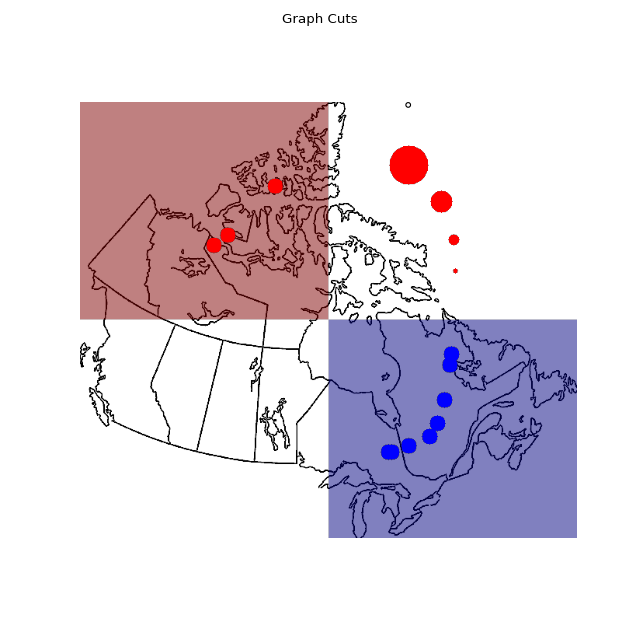

In [4]:
img = plt.imread('images/canada.bmp')
app = MyGraphCuts(img[:800,:800])
app.run()